In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')

In [2]:
try:
    del df
except:
    pass

In [3]:
header = ['datetime', 'sym', 'close', 'volume']
dtypes = {'datetime': 'str', 'sym': 'str', 'close': 'float64', 'volume': 'float64'}
parse_dates = ['datetime']
df = pd.read_csv("hist.BTCUSD.5m.csv", dtype=dtypes, parse_dates=parse_dates, index_col='datetime')
df.sort_index(inplace=True)

In [4]:
df["ma_close_short"] = df['close'].rolling(window=5).mean()

In [5]:
df["ma_close_long"] = df['close'].rolling(window=30).mean()

In [6]:
# drop all the rows that is nan caused by rolling
df.dropna(axis='index', inplace=True)

In [ ]:
ix = 0
rows = len(df)
is_open = False
stop_loss = - 0.05
df["signal"] = 0

while ix < rows:
    cur_price = df.iloc[ix]["close"]
    if not is_open and df.iloc[ix]["ma_close_short"]>df.iloc[ix]["ma_close_long"]:
        is_open = True
        open_price = df.iloc[ix]["close"]
        df.iloc[ix, 5] = 1
    elif is_open and (cur_price - open_price) / open_price < stop_loss:
        is_open = False
        open_price = cur_price
        df.iloc[ix, 5] = -1
    elif is_open and df.iloc[ix]["ma_close_short"]<=df.iloc[ix]["ma_close_long"]:
        is_open = False
        open_price = cur_price
        df.iloc[ix, 5] = -1
    ix += 1

In [7]:
df["signal"] = df.apply(lambda row: 1 if row["ma_close_short"] > row["ma_close_long"] else -1, axis='columns')

In [13]:
# close the last row 
def __signal_validation(df):
    """
    This method will change the dataset
    """
    is_close = True
    i = len(df) - 1
    while i >= 0 :
        if df.iloc[i]["signal"] == -1:
            return df
        # the last trading is opened but not closed
        elif df.iloc[i]["signal"] == 1:
            df.iloc[i, 5] = -1
            return df
        else:
            i-=1
    return df

df["signal_shift"] = df["signal"].shift(1)

# 1 means hold, -1 means sell, 0 means not hold
def gen_signal(row):
    if row["signal"]==row["signal_shift"] and row["signal"]==-1:
        return 0
    else:
        return row["signal"]
df["signal"] = df.apply(gen_signal, axis="columns")
df.drop(["signal_shift"], axis="columns", inplace=True)
df = __signal_validation(df)

In [15]:
df.tail()

,sym,close,volume,ma_close_short,ma_close_long,signal
datetime,,,,,,
2018-02-20 07:35:00,BTCUSD.BNC,11594.93,104.427098,11570.542,11496.497667,1
2018-02-20 07:40:00,BTCUSD.BNC,11645.00,211.285527,11588.542,11502.498000,1
2018-02-20 07:45:00,BTCUSD.BNC,11600.00,327.590145,11598.110,11507.511667,1
2018-02-20 07:50:00,BTCUSD.BNC,11553.18,169.079904,11593.756,11511.466667,1
2018-02-20 07:55:00,BTCUSD.BNC,11535.00,186.139272,11585.622,11514.724667,-1


In [17]:
# only get the close price when trading signal occurs
df["trading"] = abs(df["signal"]*df["close"])
# during the not hold period, the P&L should be the same as the previous close price
df["pnl"] = df['trading'].replace(to_replace=0, method='ffill')

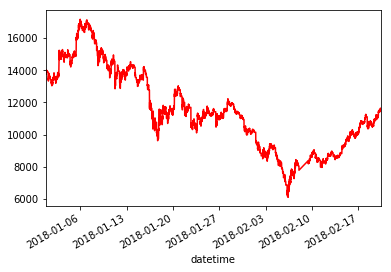

In [20]:
# equity curve plot
ax = plt.gca()
df["pnl"].plot(kind='line', y='pnl', color='red', ax=ax)
plt.show()
ax.clear()

In [21]:
df["return_rate"] = (df["close"] - df["pnl"]) / df["pnl"]

In [22]:
RISK_FREE_RATE = 0
# according to the equation of sharpe ratio
sharpe = (df["return_rate"].mean()-RISK_FREE_RATE)/df["return_rate"].std()
print("Sharpe ratio: {}".format(sharpe))

Sharpe ratio: -0.41131220948427955


In [23]:
TARGET = 0
# for downside deviation, only keep the row that has less then the target value to calculate the deviation
downside_return_rate_std = df[df["return_rate"]<TARGET]["return_rate"].std()
# the rest is the same as sharpe ratio
sortino_ratio = (df["return_rate"].mean()-RISK_FREE_RATE)/downside_return_rate_std
print("Sortino ratio: {}".format(sortino_ratio))

Sortino ratio: -0.3167625597345222


In [62]:
# maximum drawdown
df['cummax_close'] = df["close"].cummax()
df["max_drawdown"] = (df["trading"]-df['cummax_close']).cummin()/df["cummax_close"]
# df.drop(["cummax_trading"],inplace=True, axis='columns')


-1.0

In [16]:
# use the trading list instead of the whole data
cumpnl = trading_df.copy()
initial_capital = 100000
# just to prevent getting negative asset at the beginning
cumpnl["cum_pnl"] = initial_capital
cumpnl["cum_pnl"] = cumpnl["cum_pnl"] + (- cumpnl["signal"]*cumpnl["trading"]).cumsum(axis=0)
# only keep rows with odd even index because that is the result of one round of buy and sell
cumpnl = cumpnl.iloc[1::2]

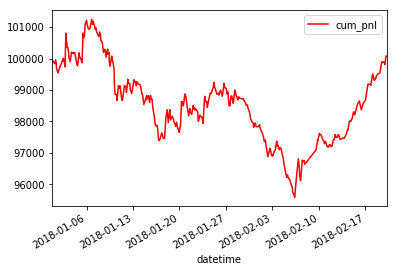

In [18]:
cumpnl["signal"]

datetime
2017-12-31 18:40:00   -1
2017-12-31 19:35:00   -1
2017-12-31 22:25:00   -1
2018-01-01 04:25:00   -1
2018-01-01 07:55:00   -1
                      ..
2018-02-19 17:05:00   -1
2018-02-19 21:30:00   -1
2018-02-19 22:50:00   -1
2018-02-20 02:50:00   -1
2018-02-20 05:45:00   -1
Name: signal, Length: 344, dtype: int64

In [24]:
i = 0
trading_pnl = {"datetime":[], "pnl":[]}
while i < len(df):
    start_row = df.iloc[i]
    if start_row["signal"] == 1:
        end_row = df.iloc[i]
        while i<len(df) and end_row["signal"] != -1:
            end_row = df.iloc[i]
            datetime = df.index[i]
            i+=1
        if end_row["signal"] == -1: 
            trading_pnl["pnl"].append(end_row["trading"] - start_row["trading"])
            trading_pnl["datetime"].append(datetime)
    i+=1

In [25]:
trading_pnl_df = pd.DataFrame({"pnl":trading_pnl["pnl"]}, index=trading_pnl["datetime"])

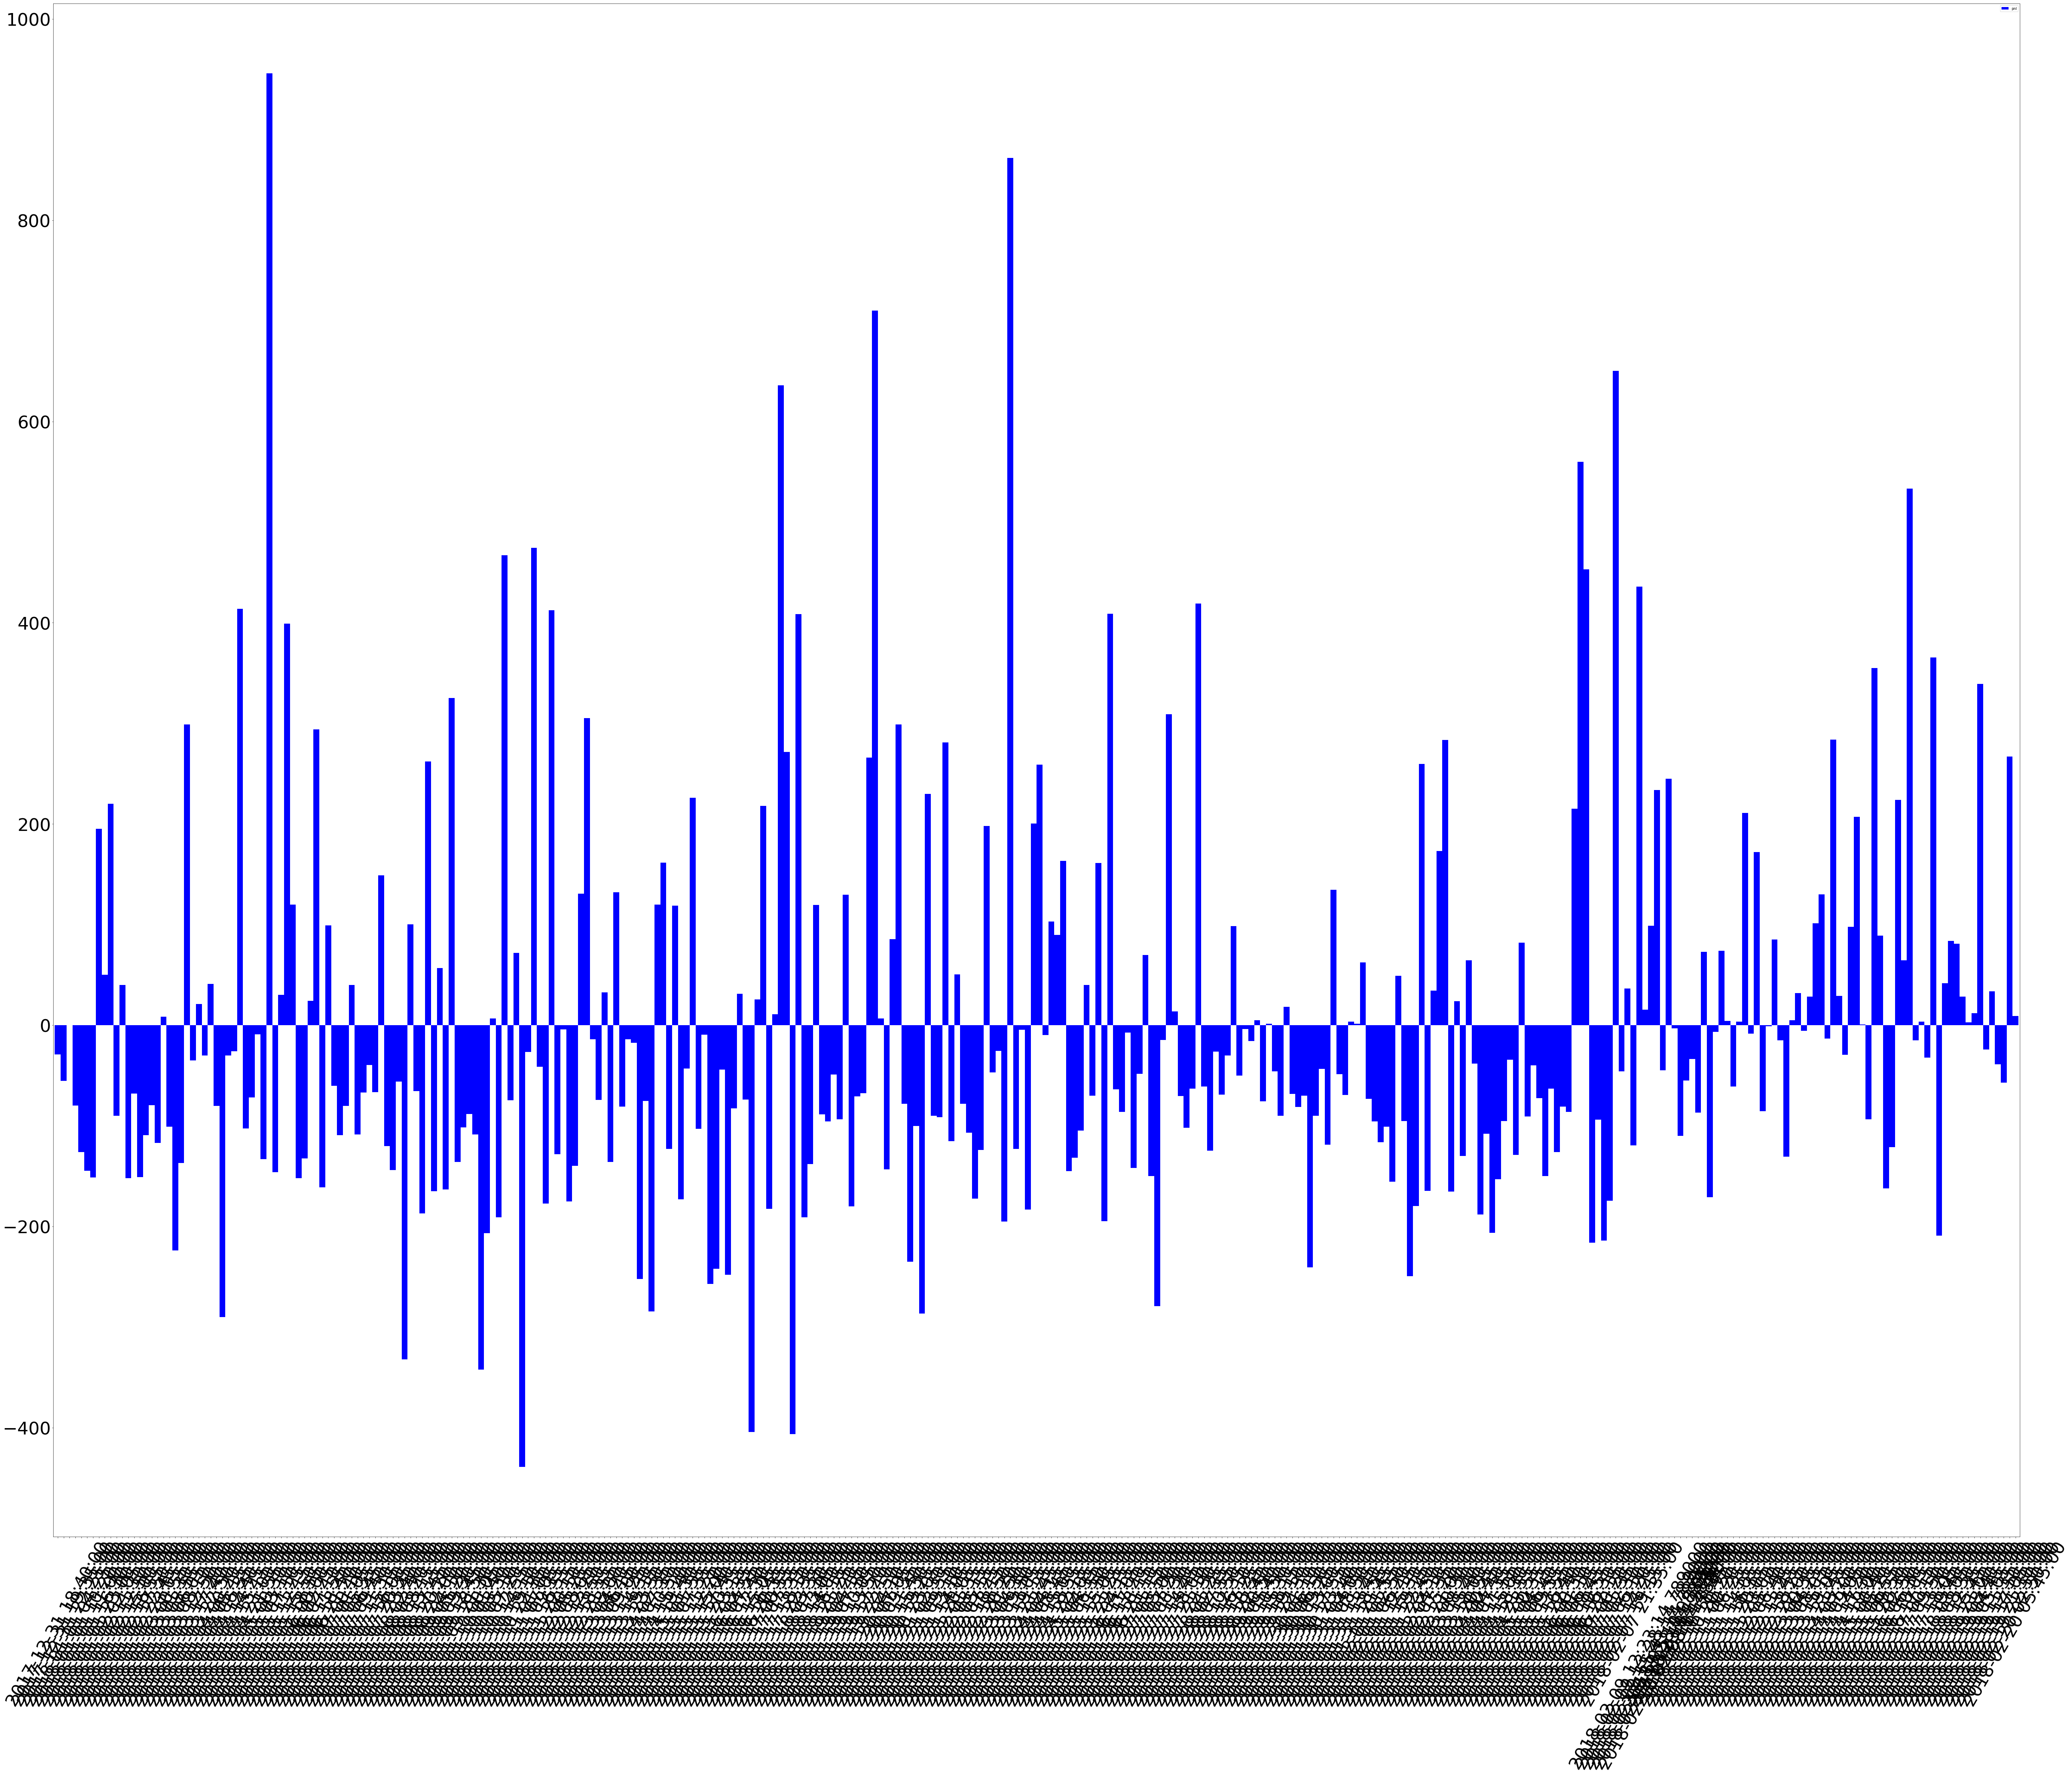

In [26]:
ax = plt.gca()
trading_pnl_df.plot.bar(y='pnl', color='blue', ax=ax, rot=60, figsize=(100,80), fontsize=50, width=1)
plt.show()

In [24]:
ax.clear()
plt.close()
plt.show()

In [1]:
from my_strategy import SMAStrategy

In [2]:
del s
del SMAStrategy

NameError: name 's' is not defined

In [3]:
s = SMAStrategy(short=5, long=27, stop_loss=-0.005)

Original data size: 14160
Processed data size: 14160


In [4]:
s.generate_signal()

In [5]:
trading_df = s.generate_trading()

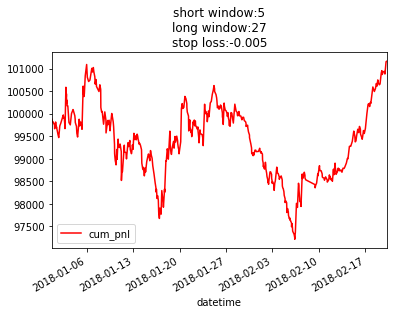

,sym,close,volume,ma_close_short,ma_close_long,signal,trading,cum_pnl
datetime,,,,,,,,
2017-12-31 18:30:00,BTCUSD.BNC,13735.36,50.891975,13815.774,13811.198889,-1,13735.36,99874.93
2017-12-31 19:35:00,BTCUSD.BNC,13760.00,20.408738,13797.876,13802.338519,-1,13760.00,99819.52
2017-12-31 22:25:00,BTCUSD.BNC,13898.98,14.870317,13924.460,13936.240000,-1,13898.98,99819.50
2018-01-01 03:50:00,BTCUSD.BNC,13435.98,45.497960,13492.224,13375.118889,-1,13435.98,99745.48
2018-01-01 04:15:00,BTCUSD.BNC,13330.05,36.474570,13383.748,13383.987778,-1,13330.05,99665.50
2018-01-01 07:50:00,BTCUSD.BNC,13610.99,13.632504,13648.076,13654.471852,-1,13610.99,99814.49
2018-01-01 10:10:00,BTCUSD.BNC,13550.00,20.933750,13592.756,13571.498889,-1,13550.00,99728.49
2018-01-01 10:20:00,BTCUSD.BNC,13509.99,16.940895,13554.152,13569.347037,-1,13509.99,99688.50
2018-01-01 10:55:00,BTCUSD.BNC,13570.01,8.480327,13561.822,13562.505185,-1,13570.01,99708.51


In [6]:
s.generate_cumpnl_curve(trading_df, save=False)

In [7]:
s.generate_sharpe_ratio()

Sharpe ratio: 0.0143528068833866


0.0143528068833866

In [8]:
s.generate_sortino_ratio()

Sortino ratio: 0.016805398064080677


0.016805398064080677

In [9]:
s.generate_maximum_drawdown(trading_df)

maximum drawdown:-0.640795548227535 short:5 long:27 stop_loss:-0.005


-0.640795548227535